In [37]:
##!python
#!/usr/bin/env python

import os
import shutil
from scipy.io import loadmat
import numpy as np
import scipy.io
from operator import itemgetter
from keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2 
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras
from keras.optimizers import RMSprop
from tensorflow.keras.layers import (
                                    Dense,
                                    Conv2D, 
                                    BatchNormalization, 
                                    ReLU, 
                                    Add,
                                    Input,
                                    MaxPooling2D,
                                    UpSampling2D,
                                    )
from keras.models import Model, load_model
from keras.losses import mean_squared_error
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from math import exp
from sklearn.model_selection import train_test_split
%matplotlib inline

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

# Limpieza de Datos/Preprocesamiento del dataset

## funciones:

In [38]:
########################################################################################################################################################
def generate_dataset_obj(obj):
    if type(obj) == np.ndarray:
        dim = obj.shape[0]
        if dim == 1:
            ret = generate_dataset_obj(obj[0])             
        else:
            ret = []
            for i in range(dim):
                ret.append(generate_dataset_obj(obj[i]))                

    elif type(obj) == scipy.io.matlab.mio5_params.mat_struct:
        ret = {}
        for field_name in obj._fieldnames:            
            field = generate_dataset_obj(obj.__dict__[field_name])
            if field_name in must_be_list_fields:
                field = [field]
                ret[field_name] = field

    else:
        ret = obj

    return ret
########################################################################################################################################################
def generate_dataset_obj(obj):
    if type(obj) == np.ndarray:
        dim = obj.shape[0]
        if dim == 1:
            ret = generate_dataset_obj(obj[0])             
        else:
            ret = []
            for i in range(dim):
                ret.append(generate_dataset_obj(obj[i]))                

    elif type(obj) == scipy.io.matlab.mio5_params.mat_struct:
        ret = {}
        for field_name in obj._fieldnames:            
            field = generate_dataset_obj(obj.__dict__[field_name])
            if field_name in must_be_list_fields:
                field = [field]
                ret[field_name] = field

    else:
        ret = obj

    return ret

########################################################################################################################################################
def print_dataset_obj(obj, depth = 0, maxIterInArray = 20):
    prefix = "  "*depth
    if type(obj) == dict:
        for key in obj.keys():
            print("{}{}".format(prefix, key))
            print_dataset_obj(obj[key], depth + 1)
    elif type(obj) == list:
        for i, value in enumerate(obj):
            if i >= maxIterInArray:
                break
            print("{}{}".format(prefix, i))
            print_dataset_obj(value, depth + 1)
    else:
        print("{}{}".format(prefix, obj))
########################################################################################################################################################
def return_image_joints(name,data):
    for item in data: # guardar coordenadas de los joints
        if item[0] == name:
            #print(item[1]) 
            return item[1]
########################################################################################################################################################
rightconnections = [
                    (0,1),(1,2),(3,4),(4,5),(2,6),
                    (3,6),(6,7),(7,8),(8,9),(10,11),
                    (11,12),(12,7),(13,7),(13,14),(14,15)
                   ]
size_img_x = 256
size_img_y = 256
def draw_img_joints(file_name, data, resize = False ):    
    # Load image
    #img = cv2.imread(Path_To_Single_Person_Images + "/" + file_name,1)  
    img = image.load_img(Path_To_Single_Person_Images + "/" + file_name)
    img = image.img_to_array(img) 
    img = img/255
    if resize:
        img = np.float32(tf.image.resize(img,(size_img_x, size_img_y)))  
    pts = return_image_joints(file_name, data)        
    #plt.imshow(img)  
    X = [x[0] for x in pts]
    Y = [y[1] for y in pts]
    X = [int(x) for x in X]
    Y = [int(y) for y in Y]
    
    for i in range(16):
        for j in range(16):
            if (i,j) in rightconnections:
                if X[i]>0 and X[j]>0 and Y[i]>0 and Y[j]>0:
                    img = cv2.line(img,(X[i],Y[i]),(X[j],Y[j]),(1,0,0),5)
                    plt.scatter(X[i], Y[i], marker="o", color="red", s=20)
                    plt.scatter(X[j], Y[j], marker="o", color="red", s=20)
                    
    plt.imshow(img)
########################################################################################################################################################
def load_image(train_data, a, b):
    train = np.asarray(train_data[a:b])
    train_image = np.zeros((b-a,size_img_x,size_img_y,3))
    for i in tqdm(range(a,b)):
        name_img = train[i][0]
        img = image.load_img(Path_To_Single_Person_Images + '/' + name_img)
        img = image.img_to_array(img)
        img_x = img.shape[1]
        img_y = img.shape[0]
        scala_x = img_x / size_img_x
        scala_y = img_y / size_img_y        
        for j in range(len(train[i][1])): # escala los puntos clave            
                train[i][1][j] = np.array([train[i][1][j][0] / scala_x, train[i][1][j][1] / scala_y])            
        img = tf.image.resize(img,(size_img_x, size_img_y))        
        img = img/255
        train_image[i] = img
    return train_image, train
########################################################################################################################################################
def MakeHeatmap(x, y, width, height, show = False):
    # Probability as a function of distance from the center derived
    # from a gaussian distribution with mean = 0 and stdv = 1
    scaledGaussian = lambda x : exp(-(1/2)*(x**2))

    imgSize = (height, width)
    center_x = x
    center_y = y

    isotropicGrayscaleImage = np.zeros((imgSize[0],imgSize[1]),np.uint8)
    
    if center_x > 0 and center_y > 0 :
        for i in range(imgSize[0]):
            for j in range(imgSize[1]):

                # find euclidian distance from center of image (x,y) 
                # and scale it to range of 0 to 2.5 as scaled Gaussian
                # returns highest probability for x=0 and approximately
                # zero probability for x > 2.5

                distanceFromCenter = np.linalg.norm(np.array([i-center_y,j-center_x]))
                #distanceFromCenter = 18*distanceFromCenter/(imgSize/2)
                scaledGaussianProb = scaledGaussian(distanceFromCenter)
                isotropicGrayscaleImage[i,j] = np.clip(scaledGaussianProb*255,0,255)   

        return isotropicGrayscaleImage
    else: 
        return isotropicGrayscaleImage
########################################################################################################################################################    
def Joints_heatmaps(lista_de_joints, heatmap_size_x, heatmap_size_y, num_heatmaps = 16, show = False):
    heatmaps = np.zeros((16,64,64))
    for i in range(num_heatmaps):
        x, y = lista_de_joints[i] 
        x = x / 4 # entre 4 por que el array es de 256x256
        y = y / 4 # entre 4 por que el array es de 256x256
        heatmaps[i] = MakeHeatmap(x, y, heatmap_size_x, heatmap_size_y)
    if show:
        plotImages(heatmaps, num_heatmaps)
    return heatmaps
########################################################################################################################################################        
def plotImages(images_arr, num_images):
    fig, axes = plt.subplots(1, num_images, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
########################################################################################################################################################    

## Cargar datos, Generación de heatmaps

In [39]:
########################################################################################################################################################
#darle formato de diccionario
matph = './mpii.mat'
decoded1 = loadmat(matph, struct_as_record=False)["RELEASE"]
must_be_list_fields = ["annolist","image","name", "annorect", "scale", "x", "y", "annopoints", "point", "id"]
# Convert to dict
dataset_obj = generate_dataset_obj(decoded1)
# Print it out
#print_dataset_obj(dataset_obj)
len(dataset_obj['annolist'][0])
#solo queremos la información en 'annolist'
dataset = dataset_obj['annolist'][0]
########################################################################################################################################################
#guardamos solo informacion de las imagenes que tienen solo una persona
train_data = []
for i in range(len(dataset)):
    if "annopoints" in dataset[i]['annorect'][0]:     
        name = dataset[i]['image'][0]['name'][0]
        tupla = [] 
        for j in range(16):     #ordena los puntos de articulaciones del id = 0 al id = 15       
            try:
                x = dataset[i]['annorect'][0]['annopoints'][0]['point'][0][j]['x'][0]
            except:
                x = -1
            try:
                y = dataset[i]['annorect'][0]['annopoints'][0]['point'][0][j]['y'][0]
            except:
                y = -1
            try:
                id = dataset[i]['annorect'][0]['annopoints'][0]['point'][0][j]['id'][0]
            except:
                id = -1          
            tupla.append((x,y,id))
        tupla = sorted(tupla, key = itemgetter(2)) # esto lo ordena
        for j in range(len(tupla)):   #quita id de las tuplas,
            tupla[j] = tupla[j][:2]
        #pasa de tupla a array
        tupla = np.asarray(tupla)        
        train_data.append((name,tupla))
#Creamos un array para guardar los nombres        
names = []
for item in train_data:#guardar nombres de las imagenes que voy a usar en "name"
    names.append(item[0])
########################################################################################################################################################

In [40]:
train_data[3][1]

array([[ -1.    ,  -1.    ],
       [ -1.    ,  -1.    ],
       [ -1.    ,  -1.    ],
       [ -1.    ,  -1.    ],
       [ -1.    ,  -1.    ],
       [ -1.    ,  -1.    ],
       [ -1.    ,  -1.    ],
       [ -1.    ,  -1.    ],
       [ -1.    ,  -1.    ],
       [533.    , 322.    ],
       [515.0945, 277.1333],
       [463.9055, 148.8667],
       [353.    , 172.    ],
       [426.    , 239.    ],
       [513.    , 288.    ],
       [552.    , 355.    ]])

In [41]:
#Crear Carpeta para guardar imagenes del dataset
Path_To_Raw_Images = 'DataSet/mpii_human_pose_v1_images'
Path_To_Single_Person_Images = 'DataSet/mpii_human_pose_v1_images/SinglePersonImagesWithData'
os.chdir(Path_To_Raw_Images)

if os.path.isdir('SinglePersonImagesWithData') is False:
    os.makedirs('SinglePersonImagesWithData')
    for images in names:
        shutil.move(images, 'SinglePersonImagesWithData')

os.chdir('../../')

#Demostración dibujar joints en imagenes con data
#draw_img_joints('060111501.jpg',train_data)
########################################################################################################################################################
#Ahora cargamos las imagenes
lista_de_imagenes, lista_de_joints = load_image(train_data,0,4)
#np.save('lista_de_imagenes', lista_de_imagenes)
########################################################################################################################################################
#Ahora creamos los heatmaps para lista_de_imagenes:
heatmap_size_x = 64
heatmap_size_y = 64 
#dibujo_test_heatmaps = Joints_heatmaps(lista_de_joints[0][1], heatmap_size_x, heatmap_size_y, show = False)
#creamos los heatmaps de nuestra data
lista_de_heatmaps = np.zeros((4,64,64,16))
for i in tqdm(range(lista_de_joints.shape[0])):
    joints = return_image_joints(lista_de_joints[i][0], lista_de_joints)
    lista_de_heatmaps[i] = np.moveaxis(Joints_heatmaps(joints, heatmap_size_x, heatmap_size_y), 0, -1) # change shape from 16x64x64 to 64x64x16
#guardamos el array    
#np.save('lista_de_heatmaps', lista_de_heatmaps)
#liberamos memoria cargando los archivos desde disco
#lista_de_heatmaps = np.load('lista_de_heatmaps.npy', mmap_mode='r')  
#lista_de_imagenes = np.load('lista_de_imagenes.npy', mmap_mode='r') 
#plotImages(lista_de_heatmaps[67], 16)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.07s/it]


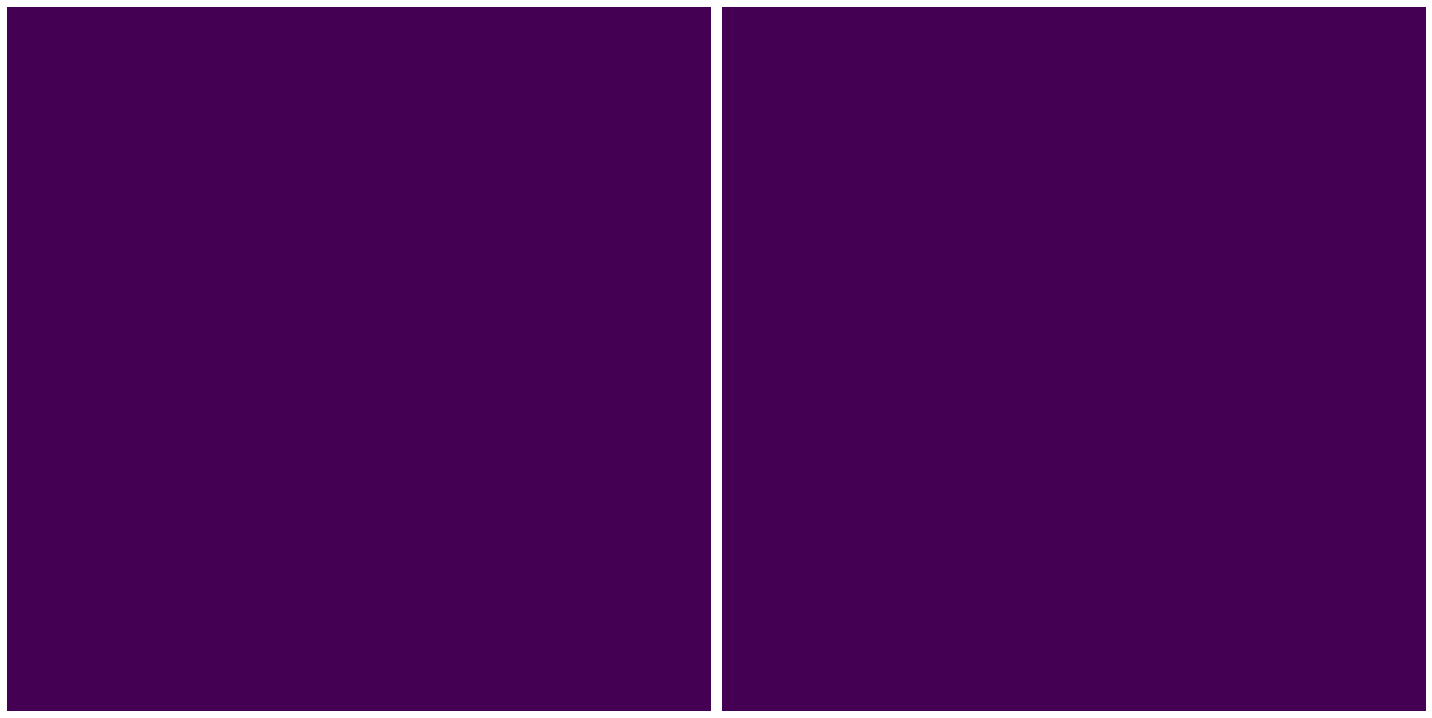

In [44]:
plotImages(np.moveaxis(lista_de_heatmaps[3], -1 , 0 ), 2)

In [43]:
lista_de_joints[3]

array(['061185289.jpg',
       array([[ -0.35555556,  -0.53333333],
       [ -0.35555556,  -0.53333333],
       [ -0.35555556,  -0.53333333],
       [ -0.35555556,  -0.53333333],
       [ -0.35555556,  -0.53333333],
       [ -0.35555556,  -0.53333333],
       [ -0.35555556,  -0.53333333],
       [ -0.35555556,  -0.53333333],
       [ -0.35555556,  -0.53333333],
       [189.51111111, 171.73333333],
       [183.14471111, 147.80442667],
       [164.94417778,  79.39557333],
       [125.51111111,  91.73333333],
       [151.46666667, 127.46666667],
       [182.4       , 153.6       ],
       [196.26666667, 189.33333333]])], dtype=object)